In [4]:
import os
import pickle
import copy
import torch
import torch.nn as nn
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.gridspec as gridspec

from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

In [9]:
def save_model(model, filename):  # 保存为CPU中可以打开的模型
    state = model.state_dict()
    x = state.copy()
    for key in x:
        x[key] = x[key].clone().cpu()
    torch.save(x, filename)
    
def loadIfExist(model, path='net_new'):
    path += '.pth'
#     print(path)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path))
        print("the latest model has been load")
            

def showimg(images, count):
    images = images.to('cpu')
    images = images.detach().numpy()
    images = images[[6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]]
    images = 255 * (0.5 * images + 0.5)
    images = images.astype(np.uint8)
    grid_length = int(np.ceil(np.sqrt(images.shape[0])))
    plt.figure(figsize=(4, 4))
    width = images.shape[2]
    gs = gridspec.GridSpec(grid_length, grid_length, wspace=0, hspace=0)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(width, width), cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()
    #     plt.tight_layout()
    plt.savefig(r'./CGAN/images/%d.png' % count, bbox_inches='tight')


In [2]:
def loadMNIST(batch_size):  # MNIST图片的大小是28*28
    trans_img = transforms.Compose([transforms.ToTensor()])
    trainset = MNIST('./MNIST', train=True, transform=trans_img, download=True)
    testset = MNIST('./MNIST', train=False, transform=trans_img, download=True)
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    return trainset, testset, trainloader, testloader


In [5]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, padding=2),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, 5, stride=1, padding=2),
            nn.LeakyReLU(0.2, True),
            nn.MaxPool2d((2, 2))
        )
        self.fc = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.dis(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class generator(nn.Module):
    def __init__(self, input_size, num_feature):
        super(generator, self).__init__()
        self.fc = nn.Linear(input_size, num_feature)  # 1*56*56
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.ReLU(True)
        )
        self.gen = nn.Sequential(
            nn.Conv2d(1, 50, 3, stride=1, padding=1),
            nn.BatchNorm2d(50),
            nn.ReLU(True),

            nn.Conv2d(50, 25, 3, stride=1, padding=1),
            nn.BatchNorm2d(25),
            nn.ReLU(True),

            nn.Conv2d(25, 1, 2, stride=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 1, 56, 56)
        x = self.br(x)
        x = self.gen(x)
        return x


In [ ]:
# class GAN(nn.Module):
    
#     def __init__(self):
#         super(GAN).__init__()
#         self.num_img = 100
#         self.z_dimension = 110
#         self.image_size = 1 * 56 * 56
        
#         self.generator = self.create_generator()
#         self.discriminator = self.create_discriminator()
#         self.

In [10]:
criterion = nn.BCELoss()
num_img = 100
z_dimension = 110
D = discriminator()
G = generator(z_dimension, 3136)  # 1*56*56
D = D.cuda()
G = G.cuda()
loadIfExist(D, 'd')
loadIfExist(G, 'g')
d_optimizer = optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = optim.Adam(G.parameters(), lr=0.0003)

the latest model has been load
the latest model has been load


In [11]:
trainset, testset, trainloader, testloader = loadMNIST(num_img)  # data

Epoch [0/1], d_loss: 0.011996, g_loss: 0.000871 D real: 0.101212, D fake: 0.000462
[8 9 9 1 6 4 7 0 0 4 0 8 3 1 8 5]


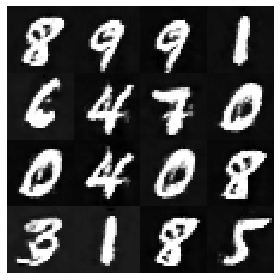

In [22]:
'''
交替训练的方式训练网络
先训练判别器网络D再训练生成器网络G
不同网络的训练次数是超参数
也可以两个网络训练相同的次数，
这样就可以不用分别训练两个网络
'''
count = 0
# 鉴别器D的训练,固定G的参数
epoch = 1
gepoch = 1
for i in range(epoch):
    for (img, label) in trainloader:
        labels_onehot = np.zeros((num_img, 10))
        labels_onehot[np.arange(num_img), label.numpy()] = 1
        #             img=img.view(num_img,-1)
        #             img=np.concatenate((img.numpy(),labels_onehot))
        #             img=torch.from_numpy(img)
        img = Variable(img).cuda()
        real_label = Variable(torch.from_numpy(labels_onehot).float()).cuda()  # 真实label为1
        fake_label = Variable(torch.zeros(num_img, 10)).cuda()  # 假的label为0

        # compute loss of real_img
        real_out = D(img)  # 真实图片送入判别器D输出0~1
        d_loss_real = criterion(real_out, real_label)  # 得到loss
        real_scores = real_out  # 真实图片放入判别器输出越接近1越好

        # compute loss of fake_img
        z = Variable(torch.randn(num_img, z_dimension)).cuda()  # 随机生成向量
        fake_img = G(z)  # 将向量放入生成网络G生成一张图片
        fake_out = D(fake_img)  # 判别器判断假的图片
        d_loss_fake = criterion(fake_out, fake_label)  # 假的图片的loss
        fake_scores = fake_out  # 假的图片放入判别器输出越接近0越好

        # D bp and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()  # 判别器D的梯度归零
        d_loss.backward()  # 反向传播
        d_optimizer.step()  # 更新判别器D参数

        # 生成器G的训练compute loss of fake_img
        for j in range(gepoch):
            z = torch.randn(num_img, 100)  # 随机生成向量
            z = np.concatenate((z.numpy(), labels_onehot), axis=1)
            z = Variable(torch.from_numpy(z).float()).cuda()
            fake_img = G(z)  # 将向量放入生成网络G生成一张图片
            output = D(fake_img)  # 经过判别器得到结果
            g_loss = criterion(output, real_label)  # 得到假的图片与真实标签的loss
            # bp and optimize
            g_optimizer.zero_grad()  # 生成器G的梯度归零
            g_loss.backward()  # 反向传播
            g_optimizer.step()  # 更新生成器G参数
            temp = real_label
    if (i % 10 == 0) and (i != 0):
        print(i)
        torch.save(G.state_dict(), r'./CGAN/Generator_cuda_%d.pkl' % i)
        torch.save(D.state_dict(), r'./CGAN/Discriminator_cuda_%d.pkl' % i)
        save_model(G, r'./CGAN/Generator_cpu_%d.pkl' % i)  # 保存为CPU中可以打开的模型
        save_model(D, r'./CGAN/Discriminator_cpu_%d.pkl' % i)  # 保存为CPU中可以打开的模型
    print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
          'D real: {:.6f}, D fake: {:.6f}'.format(
        i, epoch, d_loss.item(), g_loss.item(),
        real_scores.data.mean(), fake_scores.data.mean()))
    temp = temp.to('cpu')
    _, x = torch.max(temp, 1)
    x = x.numpy()
    print(x[[6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]])
    showimg(fake_img, count)
    plt.show()
    count += 1


In [23]:
save_model(D,'d.pth')
save_model(G,'g.pth')

In [4]:
num_img = 9


def show(images):
    images = images.detach().numpy()
    images = 255 * (0.5 * images + 0.5)
    images = images.astype(np.uint8)
    plt.figure(figsize=(4, 4))
    width = images.shape[2]
    gs = gridspec.GridSpec(1, num_img, wspace=0, hspace=0)
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(width, width), cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()
    plt.tight_layout()
    # plt.savefig(r'drive/深度学习/DCGAN/images/%d.png' % count, bbox_inches='tight')
    return width


def show_all(images_all):
    x = images_all[0]
    for i in range(1, len(images_all), 1):
        x = np.concatenate((x, images_all[i]), 0)
    print(x.shape)
    x = 255 * (0.5 * x + 0.5)
    x = x.astype(np.uint8)
    plt.figure(figsize=(9, 10))
    width = x.shape[2]
    gs = gridspec.GridSpec(10, num_img, wspace=0, hspace=0)
    for i, img in enumerate(x):
        ax = plt.subplot(gs[i])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape(width, width), cmap=plt.cm.gray)
        plt.axis('off')
        plt.tight_layout()

    # 导入相应的模型


z_dimension = 110
D = discriminator()
G = generator(z_dimension, 3136)  # 1*56*56
D.load_state_dict(torch.load(r'./CGAN/Discriminator.pkl'))
G.load_state_dict(torch.load(r'./CGAN/Generator.pkl'))
# 依次生成0到9
lis = []
for i in range(10):
    z = torch.randn((num_img, 100))  # 随机生成向量
    x = np.zeros((num_img, 10))
    x[:, i] = 1
    z = np.concatenate((z.numpy(), x), 1)
    z = torch.from_numpy(z).float()
    fake_img = G(z)  # 将向量放入生成网络G生成一张图片
    lis.append(fake_img.detach().numpy())
    output = D(fake_img)  # 经过判别器得到结果
    show(fake_img)
    plt.savefig('./CGAN/generator/%d.png' % i, bbox_inches='tight')

show_all(lis)
plt.savefig('./CGAN/generator/all.png', bbox_inches='tight')
plt.show()

NameError: name 'discriminator' is not defined